# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [19]:
# Bibliotecas estándar de Python
import math
import os

# Bibliotecas de terceros
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import spacy
import torch
from transformers import DistilBertTokenizer, DistilBertModel

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
data_path = '/datasets/imdb_reviews.tsv'
df_reviews = pd.read_csv(data_path, sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Inspección inicial de los datos
print(df_reviews.info())  # Información general del DataFrame
print(df_reviews.head())  # Primeras filas del DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

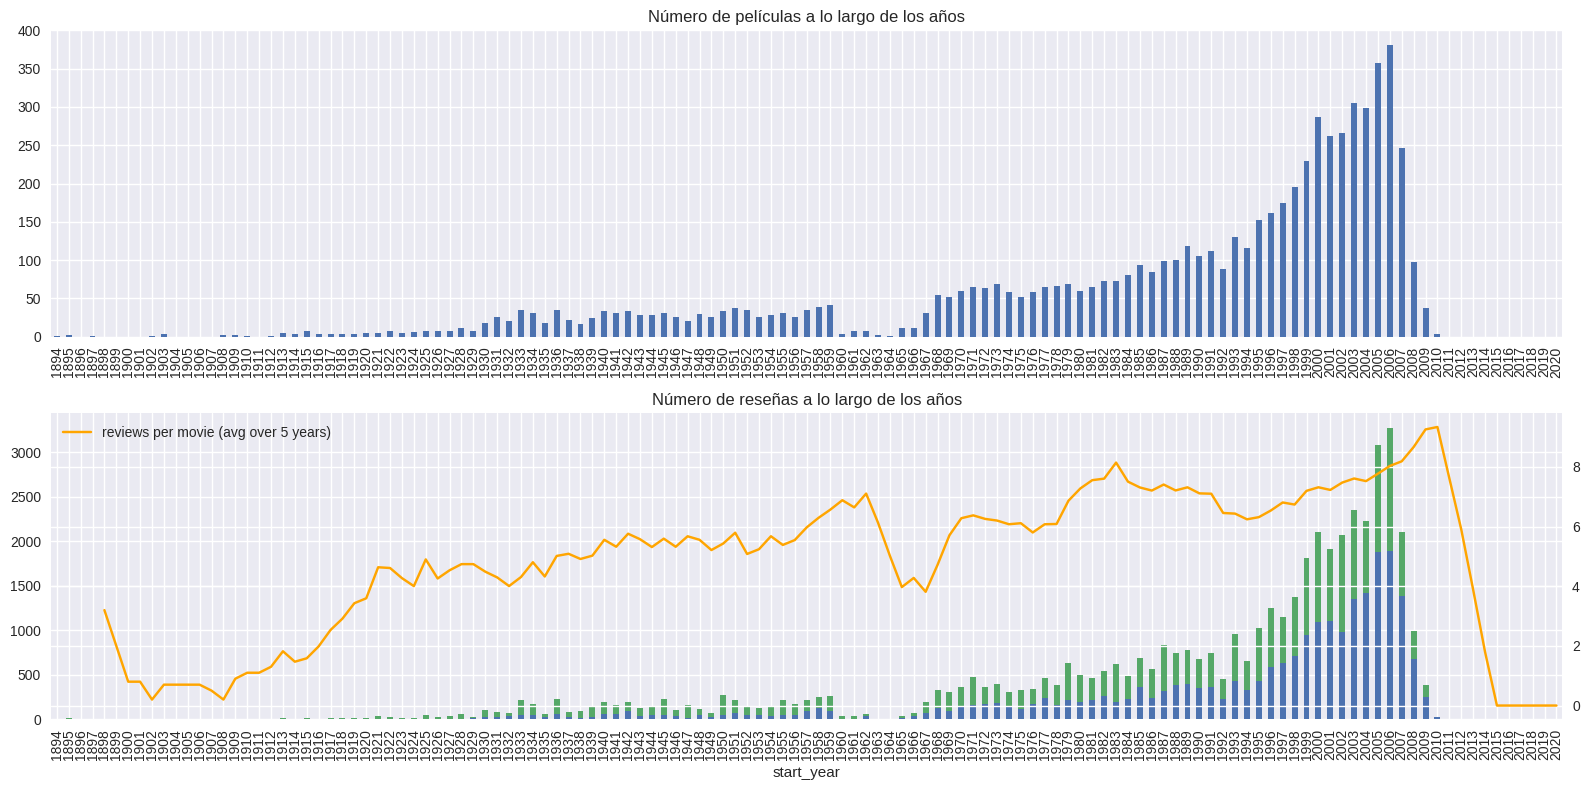

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

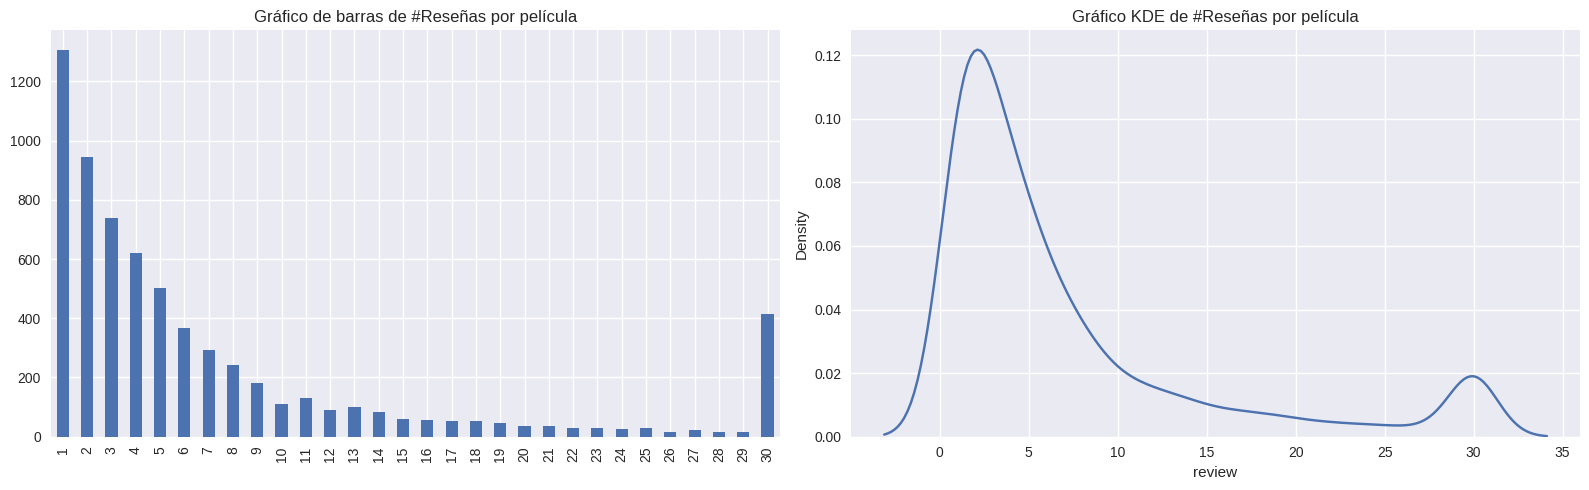

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

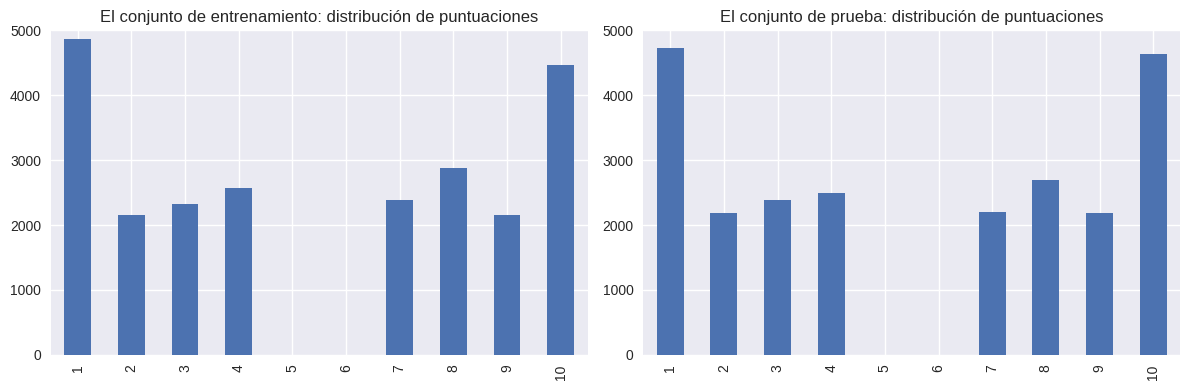

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


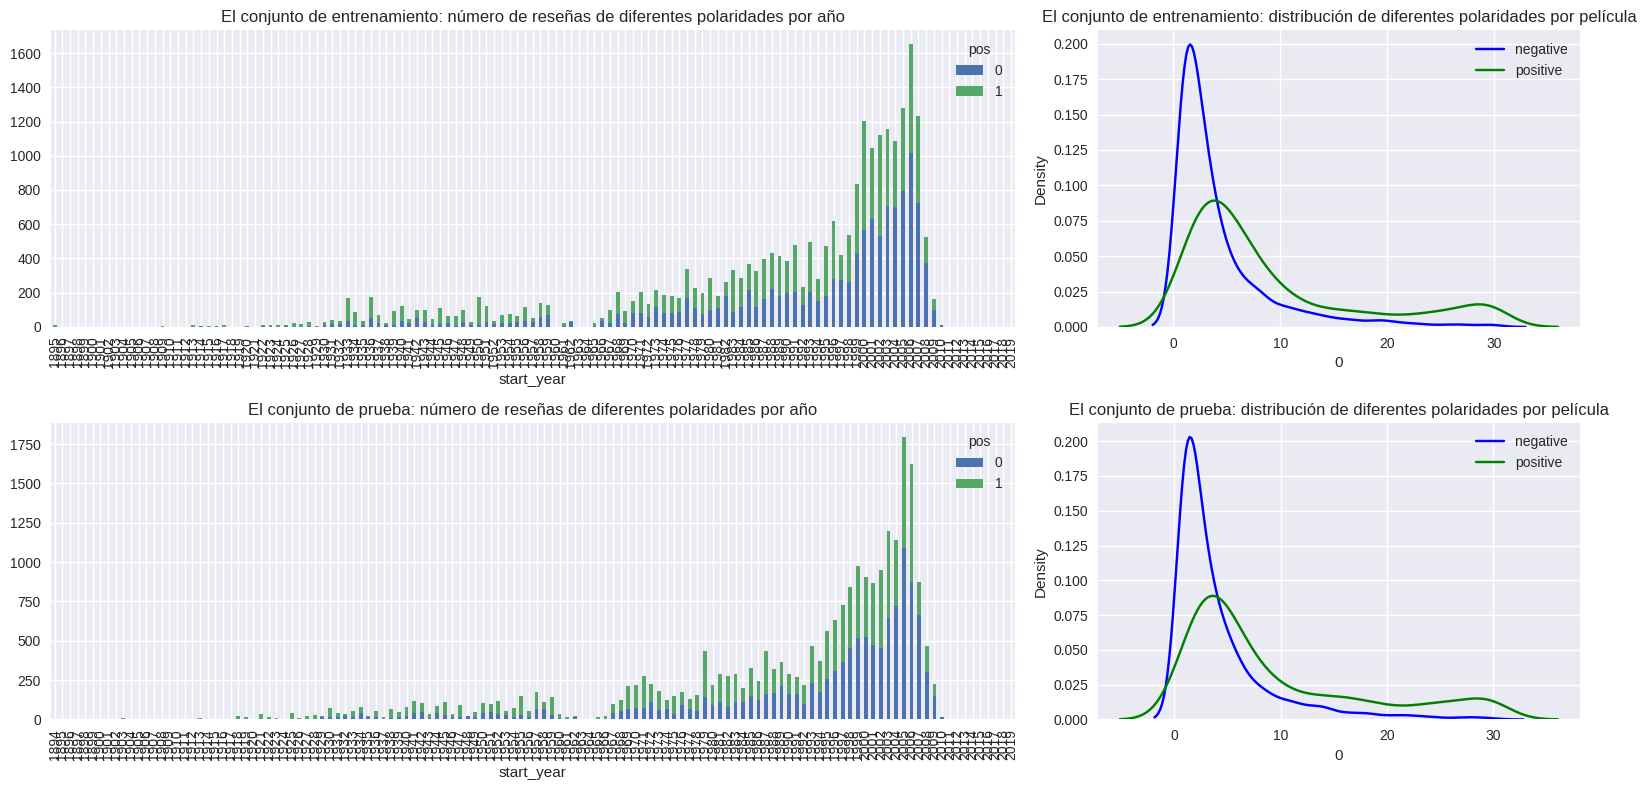

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

### Conclusiones del Análisis Exploratorio de Datos (EDA)

1. **Distribución de Reseñas por Año:**
   - Se observa una tendencia de crecimiento en la cantidad de películas y reseñas a lo largo de los años, lo que sugiere un interés creciente en evaluar y opinar sobre películas en la plataforma de IMDB o una mayor cantidad de estrenos por año
   - Los años recientes tienen un mayor número de reseñas, lo que podría estar relacionado con el aumento del acceso a internet y el uso de plataformas digitales.

2. **Distribución de Polaridad (Positivas y Negativas):**
   - La cantidad de reseñas positivas y negativas está casi balanceada, con 23,715 reseñas negativas y 23,616 reseñas positivas. Esto es ideal para el entrenamiento de modelos, ya que reduce el riesgo de sesgo hacia una de las clases.
   - Sin embargo, algunos años tienen una ligera predominancia de reseñas de un tipo sobre el otro, lo que podría afectar la representatividad de ciertos períodos.

3. **Reseñas por Película:**
   - La mayoría de las películas tienen una cantidad limitada de reseñas, con un pequeño número de películas acumulando un volumen significativamente mayor. Esta caracteristica puede terner repercuciones o influir en el modelo, ya que las películas más populares tendrán más peso en el análisis y aquellas con pocas reseñas representaran poco peso.

4. **Distribución de Calificaciones:**
   - Las calificaciones tienen una distribución uniforme tanto en el conjunto de entrenamiento como en el de prueba, lo que garantiza que el modelo será evaluado de manera justa.
   - Hay una notable concentración de calificaciones medias (4-8), lo que indica que muchas reseñas están asociadas a películas de calidad promedio.

5. **Impacto en el Modelado:**
   - El balance entre reseñas positivas y negativas asegura que los modelos tendrán un buen desempeño en ambas clases.
   - La tendencia creciente en reseñas en los años recientes destaca la relevancia de construir un modelo eficiente, ya que la cantidad de datos continuará aumentando.
   - La uniformidad en la distribución de calificaciones y polaridad entre entrenamiento y prueba asegura que las métricas de evaluación reflejan el verdadero desempeño del modelo.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
    def evaluate_model(model, train_features, train_target, test_features, test_target):

        eval_stats = {}

        fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 

        for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

            eval_stats[type] = {}

            pred_target = model.predict(features)
            pred_proba = model.predict_proba(features)[:, 1]

            # F1
            f1_thresholds = np.arange(0, 1.01, 0.05)
            f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

            # ROC
            fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
            roc_auc = metrics.roc_auc_score(target, pred_proba)    
            eval_stats[type]['ROC AUC'] = roc_auc

            # PRC
            precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
            aps = metrics.average_precision_score(target, pred_proba)
            eval_stats[type]['APS'] = aps

            if type == 'train':
                color = 'blue'
            else:
                color = 'green'

            # Valor F1
            ax = axs[0]
            max_f1_score_idx = np.argmax(f1_scores)
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
            # establecer cruces para algunos umbrales        
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('threshold')
            ax.set_ylabel('F1')
            ax.legend(loc='lower center')
            ax.set_title(f'Valor F1') 

            # ROC
            ax = axs[1]    
            ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
            # establecer cruces para algunos umbrales        
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'            
                ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower center')        
            ax.set_title(f'Curva ROC')

            # PRC
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
            # establecer cruces para algunos umbrales        
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
                marker_color = 'orange' if threshold != 0.5 else 'red'
                ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])    
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='lower center')
            ax.set_title(f'PRC')        

            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
            eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

        df_eval_stats = pd.DataFrame(eval_stats)
        df_eval_stats = df_eval_stats.round(2)
        df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))

        print(df_eval_stats)

        return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

## División entrenamiento / prueba

In [12]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación y dígitos
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenización y eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Aplicar lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Reunir tokens procesados
    return ' '.join(tokens)
df_reviews['review_norm'] = df_reviews['review_norm'] = df_reviews['review'].progress_apply(preprocess_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [13]:
print(df_reviews[['review', 'review_norm']].sample(5))

                                                  review  \
372    Fantastic documentary. A movie within a movie....   
35349  This movie caught me by surprise. For years I ...   
28694  Zombie movies are hot, I love 'em. Can't get e...   
17681  Had fun watching this film.. despite the feeli...   
26145  Ah, clichés, clichés, clichés; They're a main ...   

                                             review_norm  
372    fantastic documentary movie within movie im gl...  
35349  movie caught surprise year avoided many harold...  
28694  zombie movie hot love em cant get enough would...  
17681  fun watching film despite feeling got lot time...  
26145  ah clichs clichs clichs theyre main part wide ...  


Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [15]:
# Crear el vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=5000)

# Generar matrices de características
X_train = tfidf.fit_transform(df_reviews_train['review_norm'])
X_test = tfidf.transform(df_reviews_test['review_norm'])

In [16]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo
dummy_clf.fit(X_train, train_target)

# Realizar predicciones
dummy_predictions = dummy_clf.predict(X_test)

In [41]:
print("Reporte de clasificación para el Modelo 0 - Constante:\n")
print(classification_report(test_target, dummy_predictions, digits=4))

# F1-Score
f1_dummy = f1_score(test_target, dummy_predictions)
print(f"F1-Score del Modelo 0 - Constante: {f1_dummy:.4f}")

Reporte de clasificación para el Modelo 0 - Constante:

              precision    recall  f1-score   support

           0     0.5015    1.0000    0.6680     11803
           1     0.0000    0.0000    0.0000     11732

    accuracy                         0.5015     23535
   macro avg     0.2508    0.5000    0.3340     23535
weighted avg     0.2515    0.5015    0.3350     23535

F1-Score del Modelo 0 - Constante: 0.0000


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusión del Modelo 0:
Cualquier modelo entrenado que supere estos resultados estará aportando valor.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
# Descargar recursos de NLTK si aún no están descargados
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
# Carga de las stopwords predeterminadas
stop_words = set(stopwords.words('english'))

# Añadir palabras específicas al conjunto de stopwords
custom_stopwords = stop_words.union({'film', 'movie', 'story', 'character'})

# Remover palabras importantes que puedan ser útiles para la clasificación
custom_stopwords = custom_stopwords.difference({'not', 'no'})
print("Total de stopwords ajustadas:", len(custom_stopwords))

Total de stopwords ajustadas: 181


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Ya normalizaste las reviews en celdas más arriba, no hay porque repetir el mismo proceso, de hecho esto representa un costo extra computacionalmente
</div>

In [22]:
# Creación del vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=5000)

# Generar matrices de características para entrenamiento y prueba
train_features_1 = tfidf.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf.transform(df_reviews_test['review_norm'])

# Confirmar las dimensiones
print("Forma del conjunto de entrenamiento (TF-IDF):", train_features_1.shape)
print("Forma del conjunto de prueba (TF-IDF):", test_features_1.shape)

Forma del conjunto de entrenamiento (TF-IDF): (23796, 5000)
Forma del conjunto de prueba (TF-IDF): (23535, 5000)


In [23]:
# Creación del modelo
model_1 = LogisticRegression(random_state=42, max_iter=1000)

# Entrenar el modelo con el conjunto de entrenamiento
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

Evaluación del Modelo 1 (TF-IDF + LR):
           train  test
Exactitud    NaN   NaN
F1          0.91  0.88
APS         0.97  0.95
ROC AUC     0.97  0.95


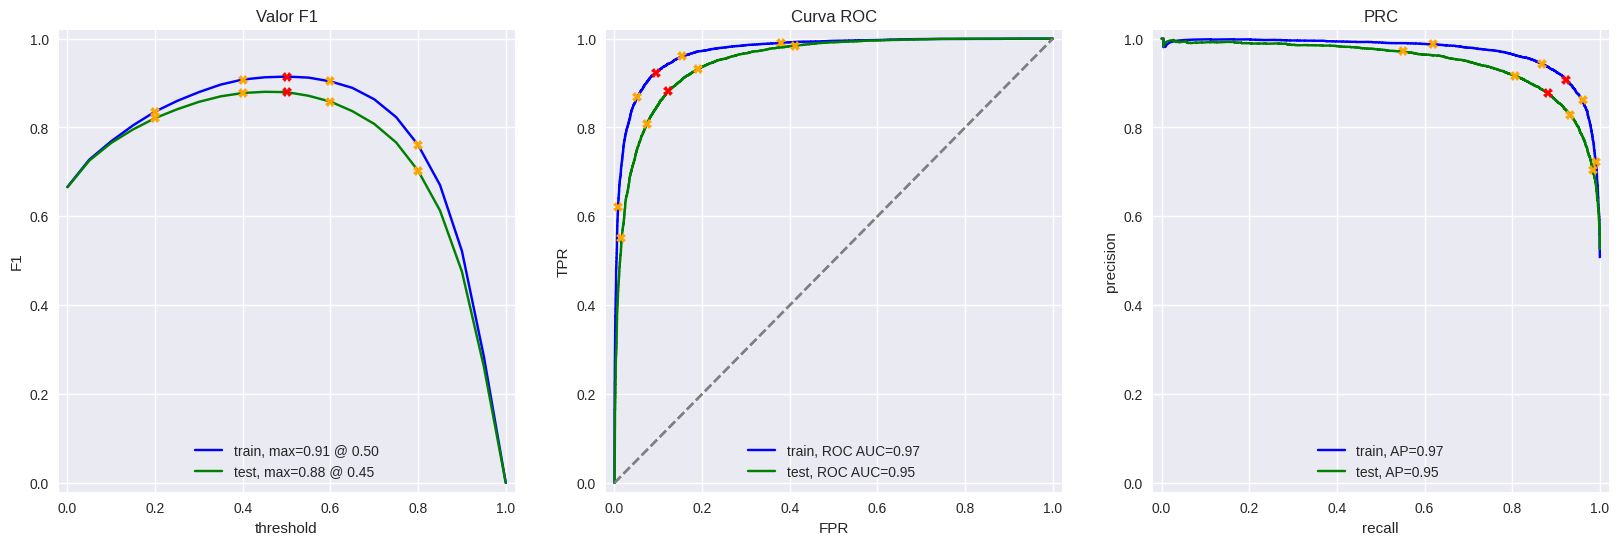

In [38]:
# Evaluación del Modelo 1
print("Evaluación del Modelo 1 (TF-IDF + LR):")
evaluate_model(
    model=model_1, 
    train_features=train_features_1, 
    train_target=train_target, 
    test_features=test_features_1, 
    test_target=test_target
)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:
# Cargar el modelo spaCy en inglés
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
# Activar tqdm para pandas
tqdm.pandas()

# Procesar las reseñas con barra de progreso
df_reviews_train['review_norm_spacy'] = df_reviews_train['review'].progress_apply(text_preprocessing_3)
df_reviews_test['review_norm_spacy'] = df_reviews_test['review'].progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [29]:
# Vectorización con TF-IDF
# Creación del vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=5000)

# Generación de las matrices de características
train_features_3 = tfidf.fit_transform(df_reviews_train['review_norm_spacy'])
test_features_3 = tfidf.transform(df_reviews_test['review_norm_spacy'])

# Confirmación de las dimensiones
print("Forma del conjunto de entrenamiento (TF-IDF):", train_features_3.shape)
print("Forma del conjunto de prueba (TF-IDF):", test_features_3.shape)

Forma del conjunto de entrenamiento (TF-IDF): (23796, 5000)
Forma del conjunto de prueba (TF-IDF): (23535, 5000)


In [30]:
# Entrenamiendo del modelo de Regresión Logística
# Creación del modelo
model_3 = LogisticRegression(random_state=42, max_iter=1000)

# Entrenamiento del modelo con el conjunto de entrenamiento
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

Evaluación del Modelo 3 (spaCy + TF-IDF + LR):
           train  test
Exactitud    NaN   NaN
F1          0.91  0.87
APS         0.97  0.94
ROC AUC     0.97  0.95


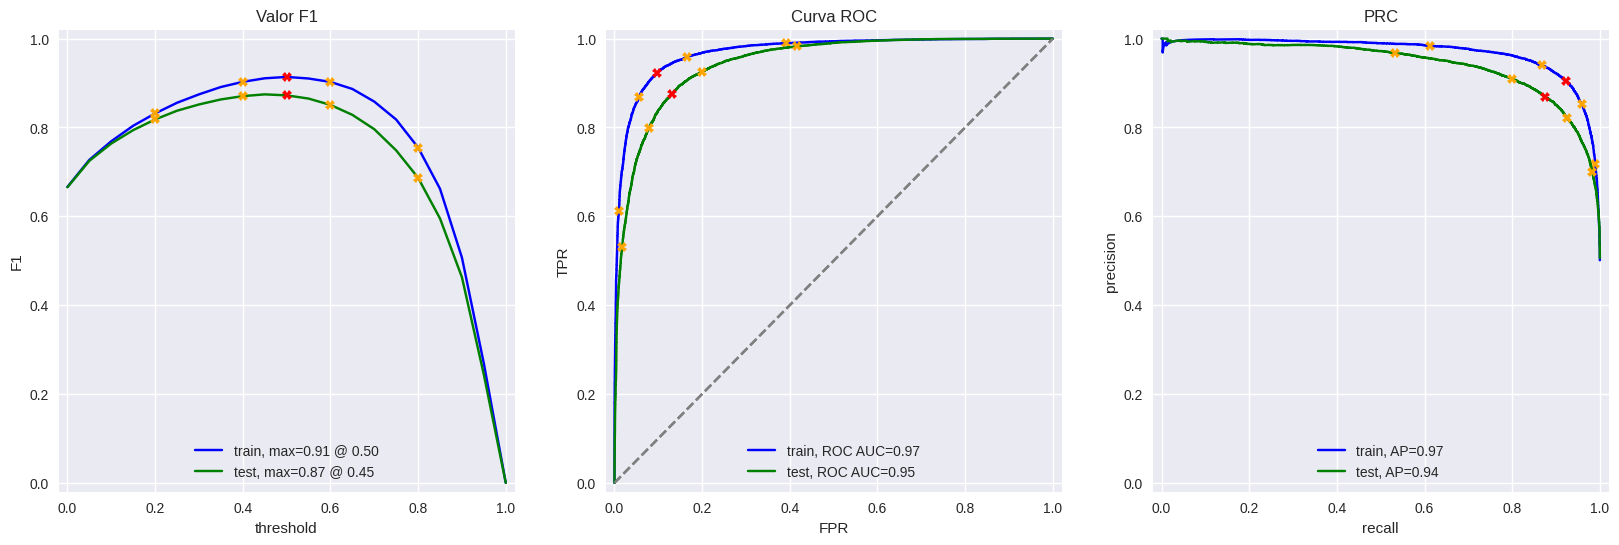

In [37]:
# Evaluación del Modelo 3
print("Evaluación del Modelo 3 (spaCy + TF-IDF + LR):")
evaluate_model(
    model=model_3, 
    train_features=train_features_3, 
    train_target=train_target, 
    test_features=test_features_3, 
    test_target=test_target
)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [32]:
print(df_reviews_train[['review', 'review_norm_spacy']].sample(5))
print(df_reviews_test[['review', 'review_norm_spacy']].sample(5))

                                                  review  \
826    When an actor has to play the role of an actor...   
18189  When I was little my parents took me along to ...   
45425  Although this isn't a "great film," there's so...   
7806   Despite some occasionally original touches, li...   
68     Bravo! Morgan Freeman is an actor, who researc...   

                                       review_norm_spacy  
826    actor play role actor , fictional factual , ta...  
18189  little parent take theater Interiors . movie w...  
45425  " great film , " compelling memorable . like c...  
7806   despite occasionally original touch , like " v...  
68     Bravo ! Morgan Freeman actor , research charac...  
                                                  review  \
9424   I watch a lot of movies. A LOT of movies. Gett...   
19429  We all seem to be in agreement. It was an exce...   
8051   I really like this film because of all the sta...   
4823   In the light of the recent typhoon tha

In [33]:
# Vectorización con TF-IDF

tfidf = TfidfVectorizer(max_features=5000)

# Generar matrices de características
train_features_4 = tfidf.fit_transform(df_reviews_train['review_norm_spacy'])
test_features_4 = tfidf.transform(df_reviews_test['review_norm_spacy'])

# Confirmar dimensiones
print("Forma del conjunto de entrenamiento (TF-IDF):", train_features_4.shape)
print("Forma del conjunto de prueba (TF-IDF):", test_features_4.shape)

Forma del conjunto de entrenamiento (TF-IDF): (23796, 5000)
Forma del conjunto de prueba (TF-IDF): (23535, 5000)


In [34]:
# Entrenamiento del modelo LightGBM

# Creación del modelo LightGBM
model_4 = LGBMClassifier(random_state=42)

# Entrenamiento del modelo con el conjunto de entrenamiento
model_4.fit(train_features_4, train_target)

LGBMClassifier(random_state=42)

spaCy, TF-IDF y LGBMClassifier:
           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


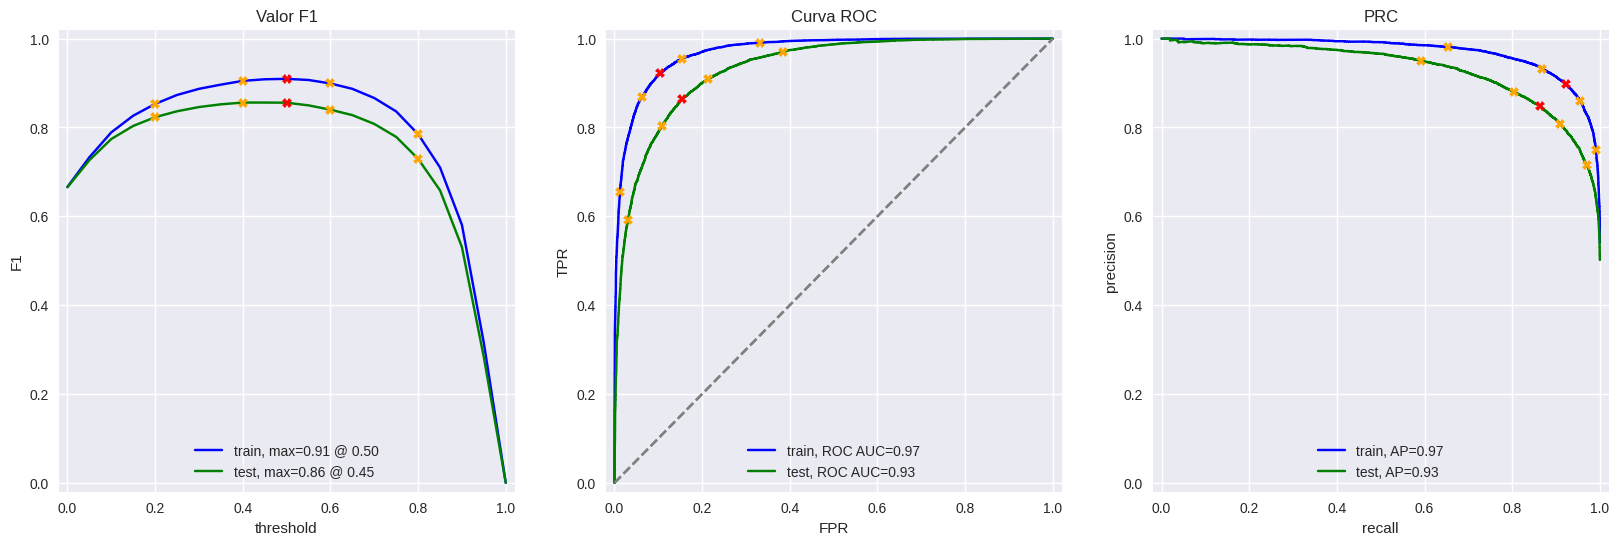

In [43]:
# Evaluación del Modelo 4 
print("spaCy, TF-IDF y LGBMClassifier:")
evaluate_model(
    model=model_4, 
    train_features=train_features_4, 
    train_target=train_target, 
    test_features=test_features_4, 
    test_target=test_target
)

###  Modelo 9 - BERT

[Errno 13] Permission denied: '/home/jovyan/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333.lock'
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Modelo DistilBERT inicializado correctamente.


Generando embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Generando embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluación del Modelo BERT (DistilBERT + Logistic Regression):
           train  test
Exactitud    NaN   NaN
F1          0.94  0.75
APS         0.99  0.85
ROC AUC     0.99  0.85


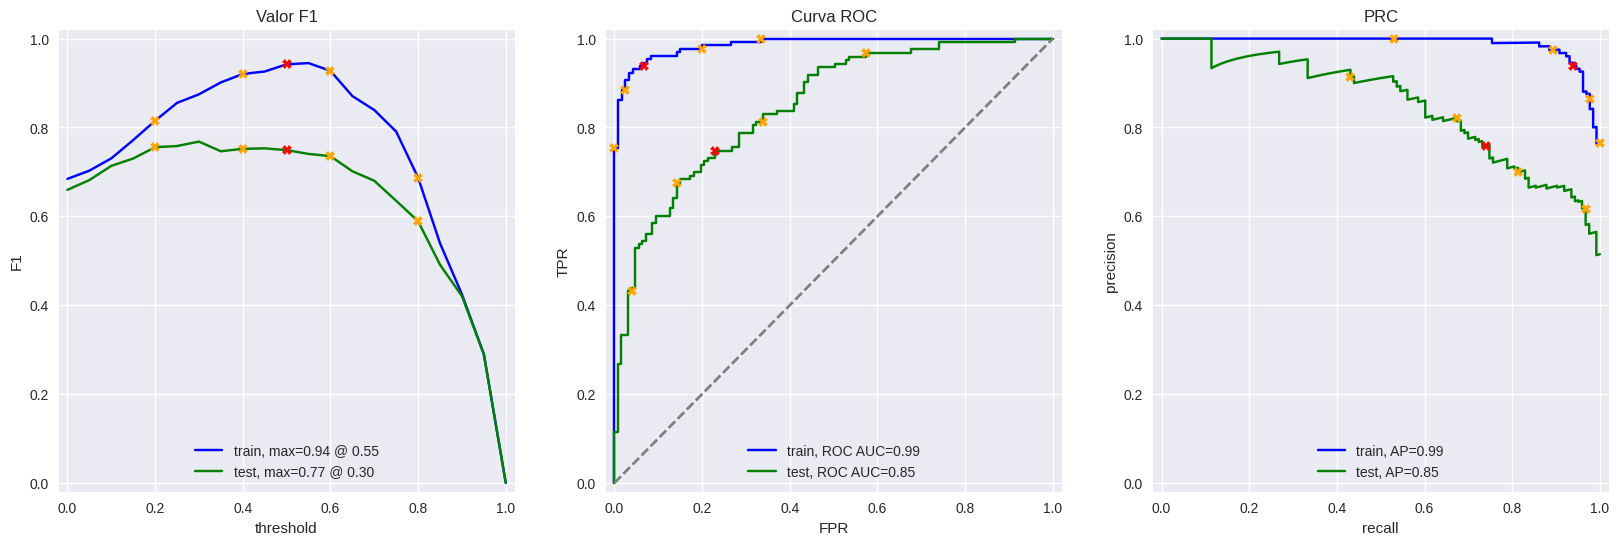

In [45]:
# Cambiar el directorio de caché a uno local con permisos
os.environ['TRANSFORMERS_CACHE'] = './transformers_cache'
if not os.path.exists('./transformers_cache'):
    os.makedirs('./transformers_cache', exist_ok=True)

# Tamaño de la muestra reducido
sample_size = 250

# Crear muestras reducidas para entrenamiento y prueba
df_train_sample = df_reviews_train.sample(sample_size, random_state=42)
df_test_sample = df_reviews_test.sample(sample_size, random_state=42)

# Inicializar DistilBERT y el tokenizer
try:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir='./transformers_cache')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased', cache_dir='./transformers_cache')
    print("Modelo DistilBERT inicializado correctamente.")
except Exception as e:
    print("Error al inicializar DistilBERT:", e)

# Mover el modelo a la CPU (para evitar problemas si no hay GPU)
device = torch.device('cpu')
model.to(device)

# Función para generar embeddings usando DistilBERT
def bert_embeddings(texts, tokenizer, model, max_length=512, batch_size=16):
    embeddings = []
    model.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="Generando embeddings"):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(
            batch.tolist(),
            max_length=max_length,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        tokens = {key: val.to(device) for key, val in tokens.items()}
        with torch.no_grad():
            outputs = model(**tokens)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generar embeddings para la muestra de entrenamiento y prueba
try:
    train_embeddings = bert_embeddings(df_train_sample['review_norm'], tokenizer, model)
    test_embeddings = bert_embeddings(df_test_sample['review_norm'], tokenizer, model)
except Exception as e:
    print("Error durante la generación de embeddings:", e)

# Crear el modelo de regresión logística
bert_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo
try:
    bert_classifier.fit(train_embeddings, df_train_sample['pos'])
except Exception as e:
    print("Error durante el entrenamiento:", e)

print("Evaluación del Modelo BERT (DistilBERT + Logistic Regression):")
evaluate_model(
    model=bert_classifier,  
    train_features=train_embeddings,
    train_target=df_train_sample['pos'], 
    test_features=test_embeddings, 
    test_target=df_test_sample['pos']  
)

In [46]:
print(train_embeddings.shape)
print(test_embeddings.shape)

(250, 768)
(250, 768)


In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [54]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(preprocess_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actor looked really old disinterested got...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writer really cared s...
5,"The movie had its upsides and downsides, but I...",movie upside downside feel like overall decent...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke land everyon...
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...


In [57]:
# Modelo 1  (NLTK, TF-IDF y LR)
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.88: simply like kind movie
0.61: well bored felt asleep middle movie
0.88: really fascinated movie
0.57: even actor looked really old disinterested got paid movie soulless cash grab
0.58: didnt expect reboot good writer really cared source material
0.53: movie upside downside feel like overall decent flick could see going see
0.30: rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.44: launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


In [58]:
# Modelo 3 - spaCy, TF-IDF y LR
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_3.predict_proba(tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.19: simply like kind movie
0.05: well bored felt asleep middle movie
0.42: really fascinated movie
0.34: even actor looked really old disinterested got paid movie soulless cash grab
0.24: didnt expect reboot good writer really cared source material
0.65: movie upside downside feel like overall decent flick could see going see
0.03: rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.98: launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


In [60]:
# Modelo 4 - spaCy, TF-IDF y LGBMClassifier
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_4.predict_proba(tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.59: simply like kind movie
0.17: well bored felt asleep middle movie
0.63: really fascinated movie
0.61: even actor looked really old disinterested got paid movie soulless cash grab
0.63: didnt expect reboot good writer really cared source material
0.66: movie upside downside feel like overall decent flick could see going see
0.26: rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.85: launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


In [61]:
# Modelo BERT
texts = my_reviews['review_norm']
my_reviews_embeddings = bert_embeddings(
    texts, 
    tokenizer=tokenizer, 
    model=model, 
    max_length=512, 
    batch_size=16
)

my_reviews_pred_prob = bert_classifier.predict_proba(my_reviews_embeddings)[:, 1]

# Imprimir las probabilidades y las reseñas correspondientes
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')


Generando embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

0.05: simply like kind movie
0.08: well bored felt asleep middle movie
0.08: really fascinated movie
0.05: even actor looked really old disinterested got paid movie soulless cash grab
0.08: didnt expect reboot good writer really cared source material
0.04: movie upside downside feel like overall decent flick could see going see
0.02: rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.89: launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


## Conclusiones

El modelo 1 (TF-IDF + LR) es el mejor modelo del proyecto porque:
  - Superó el umbral de F1-Score de 0.85 y tubo la mejor calificación  con un valor de 0.8790. Además, tiene el mayor accuracy, lo que refuerza su desempeño.
  - Mostró un buen balance entre las métricas de precisión, recall y F1-Score.
  - Tiene un AUC alto, indicando una excelente capacidad discriminativa.
  - Fue computacionalmente eficiente en comparación con BERT ya que se requiero un menor tiempo de proceso.

El modelo BERT no se pudo realizar de manera completa debido a que no se cuenta con una tarjeta grafica por lo que se decidio en este caso experimentar con una muestra reducida, demostrando que el pipeline puede extenderse a embeddings más avanzados en el futuro, si se dispone de más recursos computacionales, pudiendo ser un mejor modelo pero que requiere de mayor recursos.
